# __Quality Assesment Notebook for the auto-correlation of quasars in Mocks__

Conclusion:
    - What is the input evolution of bias QSO?
    - different nb of healpix pixels in data (1215) and randoms (1214)
    - data go down to z = 1.796 when randoms only to z = 1.8
    - get the way to send jobs on NERSC
    - run with more randoms
    - less redshift bins to compute the correlation
    - Get correct errors using https://github.com/igmhub/picca/pull/442

In [4]:
import fitsio
import scipy as sp
import scipy.constants
import glob
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import h5py
import os

import picca.constants
from picca import wedgize

%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
plt.rc('text',usetex=True)

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
nside = 16

In [6]:
mock = {}
mock['mock_ver'] = 'v4.0.0'
mock['quick_ver'] = 'quick-2.0'
mock['mock_base'] = '/project/projectdirs/desi/mocks/lya_forest/london/'+mock['mock_ver']+'/'
mock['Catalogs'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog/'
mock['Correlations'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/'

## __Compare catalogs__

In [7]:
# Catalogs
cat_path = {'desiDRQ':mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits',
            'random':mock['mock_base']+'/master_randoms.fits.gz'}
redshift_key = {'desiDRQ':'Z','random':'Z'}

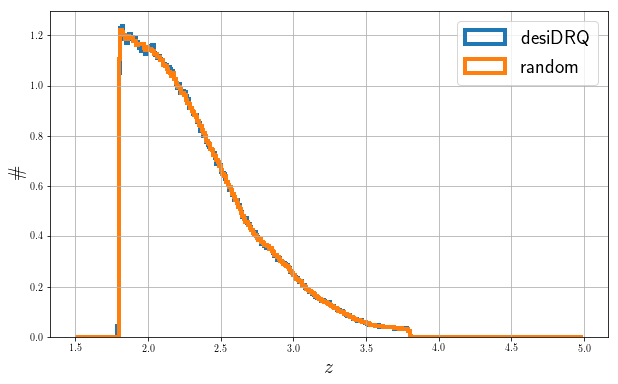

In [8]:
bins = sp.arange(1.5,5.,0.01)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

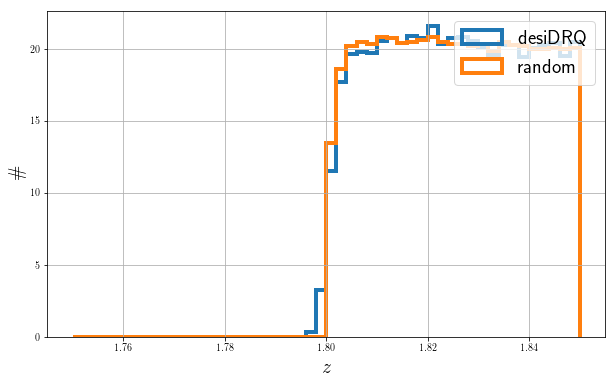

In [9]:
bins = sp.arange(1.75,1.85,0.002)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

[]

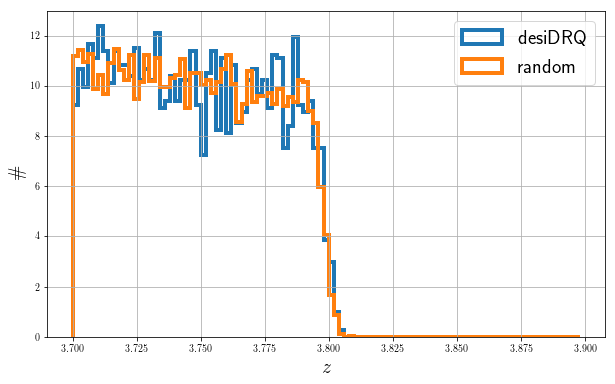

In [10]:
bins = sp.arange(3.7,3.9,0.002)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()
plt.plot()

## __Density of objects on the sky__

The following function allows to have a 2d histogram

In [11]:
def Get_2DTProfile(ar1, ar2, ar3, nbBinsX, nbBinsY,we=None):

    if we is None:
        we = sp.ones_like(ar1)
    d = sp.array(list(zip(ar1,ar2,ar3)))
    number, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1))
    weight, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we  )
    mean,   axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*ar3)
    err,    axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*(ar3**2.))

    w = number>1
    mean[w]   /= weight[w]
    err[w]    = sp.sqrt((err[w]/weight[w]-mean[w]**2.)/number[w])

    mean   = mean[:,:,0]
    err    = err[:,:,0]
    number = number[:,:,0]

    return mean, err, number

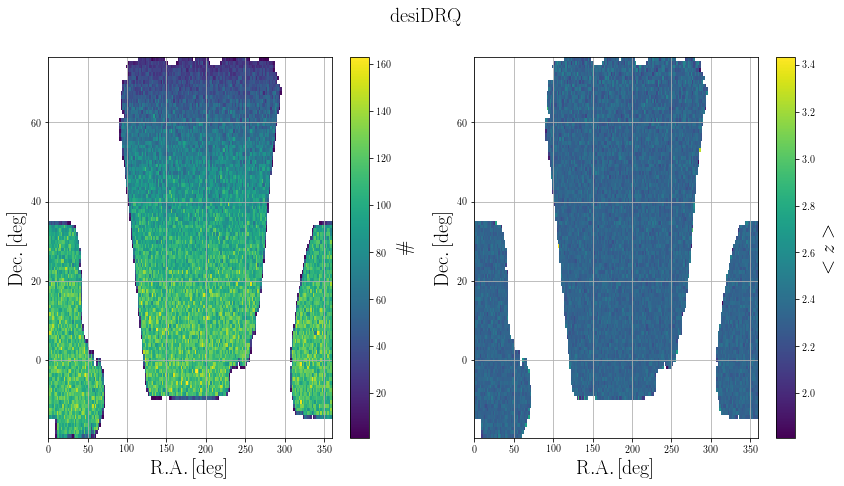

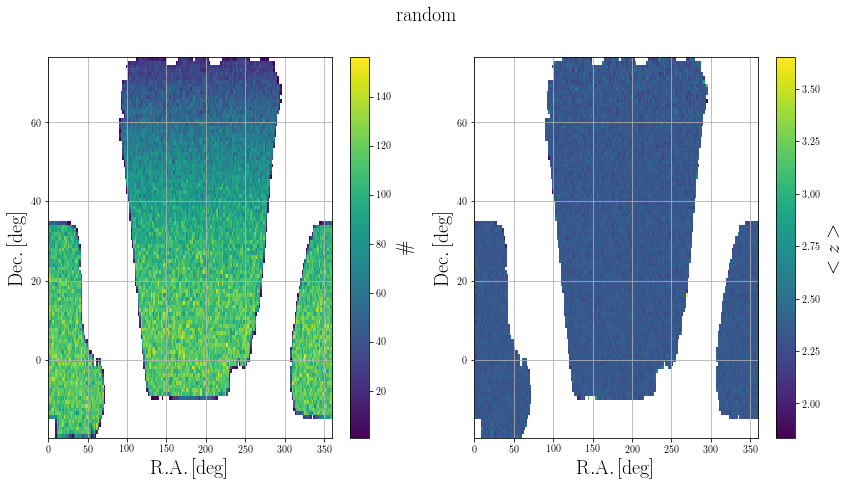

In [12]:
sp.random.seed(42)
nbQSO = 1000000
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]
    h.close()
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    
    mean_nb, err_nb, number_nb = Get_2DTProfile(ra, dec, sp.ones(ra.size), 200, 100)
    number_nb = sp.transpose(number_nb)
    number_nb[number_nb==0.] = sp.nan
    plot1 = ax1.imshow(number_nb, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar1 = plt.colorbar(plot1, ax=ax1)
    cbar1.set_label(r'$\#$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()
    
    mean_z, err_z, number_z = Get_2DTProfile(ra, dec, z, 200, 100)
    mean_z = sp.transpose(mean_z)
    number_z = sp.transpose(number_z)
    mean_z[number_z==0.] = sp.nan
    plot2 = ax2.imshow(mean_z, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar2 = plt.colorbar(plot2,ax=ax2)
    cbar2.set_label(r'$<z>$',size=20)
    cbar2.update_ticks()
    ax2.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax2.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax2.grid()
    
    plt.subplots_adjust(wspace=0.2)

## __Convert random catalogs to DRQ__

The first step we have to do is look at how many objects there are in the simulated data
and its simulated randoms.

We also need to look if the number of different healpix pixels is the same.

In [13]:
### Data
h = fitsio.FITS(mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits')
ra = h[1]['RA'][:]
dec = h[1]['DEC'][:]
z = h[1]['Z'][:]
phi = ra*sp.pi/180.
th = sp.pi/2.-dec*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
print(' There are {} objects in the data catalog'.format(ra.size) )
print(' Across {} different healpix pixels of nside={}'.format(sp.unique(pix).size,nside) )
print(' with redshift in {} < z < {}'.format(z.min(), z.max()))
print('\n')
h.close()

### Randoms
h = fitsio.FITS(mock['mock_base']+'/master_randoms.fits.gz')
ra = h[1]['RA'][:]
dec = h[1]['DEC'][:]
z = h[1]['Z'][:]
phi = ra*sp.pi/180.
th = sp.pi/2.-dec*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
print(' There are {} objects in the random catalog'.format(ra.size) )
print(' Across {} different healpix pixels of nside={}'.format(sp.unique(pix).size,nside) )
print(' with redshift in {} < z < {}'.format(z.min(), z.max()))
print('\n')
h.close()

 There are 1076372 objects in the data catalog
 Across 1215 different healpix pixels of nside=16
 with redshift in 1.796119326821999 < z < 3.8047252345203697


 There are 46440810 objects in the random catalog
 Across 1214 different healpix pixels of nside=16
 with redshift in 1.7999989554114575 < z < 3.8082375286049395




In [36]:
nbData = 1076372
nbRandoms = 2*nbData

### Data
h = fitsio.FITS(mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits')
data = {}
for k in ['RA','DEC','THING_ID','PLATE','MJD','FIBERID','Z']:
    data[k] = h[1][k][:]
h.close()
phi = data['RA']*sp.pi/180.
th = sp.pi/2.-data['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
data['PIX'] = pix

### Randoms
h = fitsio.FITS(mock['mock_base']+'/master_randoms.fits.gz')
rand = {}
for k in ['RA','DEC','Z']:
    rand[k] = h[1][k][:]
for k in ['THING_ID','PLATE','MJD','FIBERID']:
    rand[k] = data['THING_ID'].max()+1+sp.arange(rand['RA'].size)
h.close()
phi = rand['RA']*sp.pi/180.
th = sp.pi/2.-rand['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
rand['PIX'] = pix

### Same HEALpix
w = sp.in1d(data['PIX'],rand['PIX'])
print((~w).sum())
for k,v in data.items():
    v = v[w]
w = sp.in1d(rand['PIX'],data['PIX'])
print((~w).sum())
for k,v in rand.items():
    v = v[w]

### Save data
print(data['RA'].size)
assert nbData<=data['RA'].size
w = sp.random.choice(sp.arange(data['RA'].size), size=nbData, replace=False)
out = fitsio.FITS(mock['Catalogs']+'/QSO_D_'+str(nbData)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in data.items() if k not in ['PIX'] ]
names = [ k for k in data.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()
    
### Save randoms
assert nbRandoms<=rand['RA'].size
w = sp.random.choice(sp.arange(rand['RA'].size), size=nbRandoms, replace=False)
out = fitsio.FITS(mock['Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in rand.items() if k not in ['PIX'] ]
names = [ k for k in rand.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()

4
0
1076372


## __Compute the auto-correlations of quasars__

Simply run the following command in your terminal

In [15]:
zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10']
#zint = ['0:2.2','2.2:2.6','2.6:3.0','3.0:3.4','3.4:10']

In [37]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    if not os.path.isdir(mock['Correlations']+'/co_z_{}_{}/'.format(zmin,zmax)):
        os.mkdir(mock['Correlations']+'/co_z_{}_{}/'.format(zmin,zmax))

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/QSO_D_'+str(nbData)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DD ;'
    #print(cmd)
    #print()

    cmd += ' srun --time 30 --qos debug  do_co.py'
    cmd += ' --out '+mock['Correlations']+'/co_z_{}_{}/co_DR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/QSO_D_'+str(nbData)+'.fits'
    cmd += ' --drq2 '+mock['Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DR ;'
    #print(cmd)
    #print()

    cmd += ' srun --time 30 --qos debug  do_co.py'
    cmd += ' --out '+mock['Correlations']+'/co_z_{}_{}/co_RR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr RR ;'
    #print(cmd)
    #print()
    
    cmd += ' srun --time 30 --qos debug  export_co.py'
    cmd += ' --DD-file '+mock['Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --RR-DR-dir '+mock['Correlations']+'/co_z_{}_{}/'.format(zmin,zmax)
    cmd += ' --out '+mock['Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' ;'
    #if os.path.isfile(mock['Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)):
    #    continue
    print(cmd)
    print()

 srun --time 30 --qos debug do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_0_2.2/co_DD_z_0_2.2.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//QSO_D_1076372.fits --z-cut-min 0 --z-cut-max 2.2 --type-corr DD ; srun --time 30 --qos debug  do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_0_2.2/co_DR_z_0_2.2.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//QSO_D_1076372.fits --drq2 /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//QSO_R_2152744.fits --z-cut-min 0 --z-cut-max 2.2 --type-corr DR ; srun --time 30 --qos debug  do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_0_2.2/co_RR_z_0_2.2.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//QSO_R_2152744.fits --z-cut-min 0 --

## __Fit the 3D correlations__

In [17]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    
    corr = mock['Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    correxp = mock['Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)
    fitdir = mock['Correlations']+'Fit/QSO_QSO/co_z_{}_{}/'.format(zmin,zmax)

    ### Compute zeff
    if not os.path.isfile(corr): continue
    
    h = fitsio.FITS(corr)
    we = h['COR']['WE'][:]
    we = we.sum(axis=0)
    z = h['ATTRI']['Z'][:]
    rp = h['ATTRI']['RP'][:]
    rt = h['ATTRI']['RT'][:]
    r = sp.sqrt(rp**2. + rt**2.)
    w = (r>80.) & (r<120.)
    zeff = sp.sum( z[w]*we[w] )/sp.sum( we[w] )
    h.close()
    print(zeff)
    print(correxp)
    print(fitdir)
    print()

2.001259437269122
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_0_2.2/co_z_0_2.2-exp.fits.gz
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/Fit/QSO_QSO/co_z_0_2.2/

2.291612299891309
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_2.2_2.4/co_z_2.2_2.4-exp.fits.gz
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/Fit/QSO_QSO/co_z_2.2_2.4/

2.4882082120651288
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_2.4_2.6/co_z_2.4_2.6-exp.fits.gz
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/Fit/QSO_QSO/co_z_2.4_2.6/

2.6868361730900414
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//co_z_2.6_2.8/co_z_2.6_2.8-exp.fits.gz
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/Fit/QSO_QSO/co_z_2.6_2.8/

2.8878115123

## __Plot the 3D correlation__

In [27]:
toPlot = {}
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    if not os.path.isfile(mock['Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)):
        continue
    toPlot['Mockz{}{}'.format(zmin,zmax)] = { 'CORR':mock['Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax),
                                            'FIT':mock['Correlations']+'Fit/QSO_QSO/co_z_{}_{}/result.h5'.format(zmin,zmax),
                                            'NAME':'QSOxQSO'}

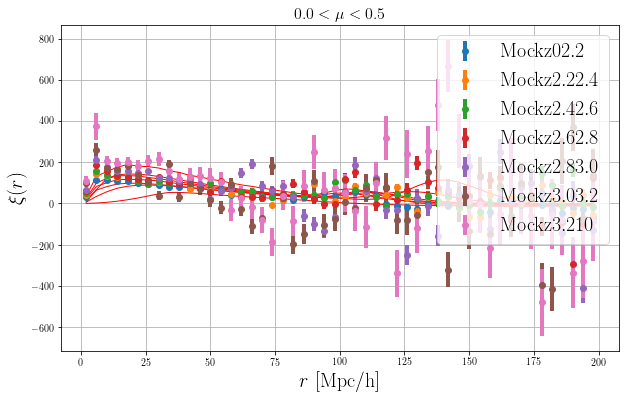

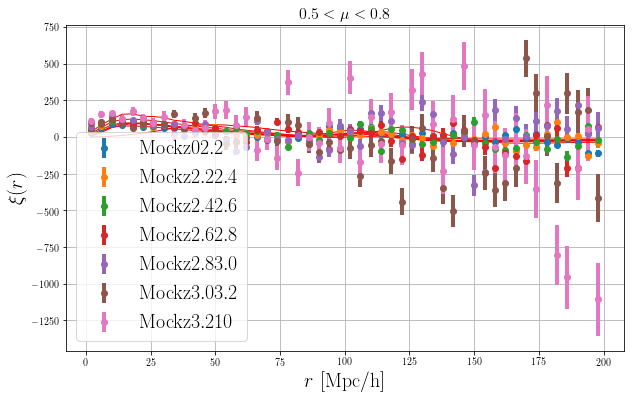

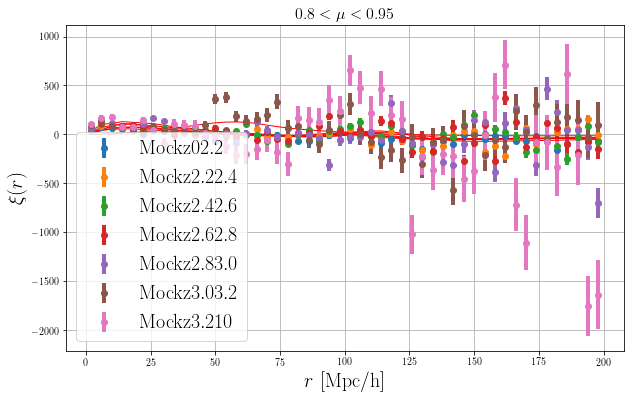

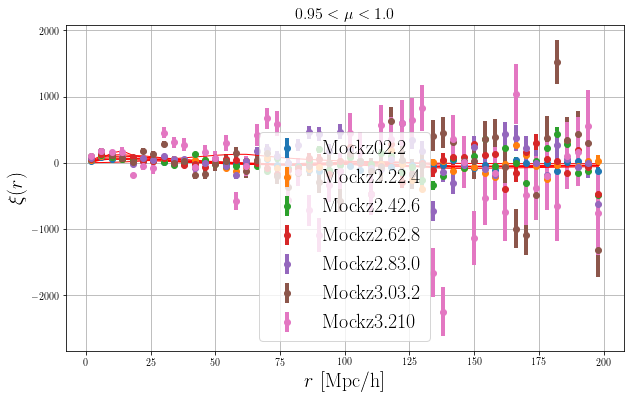

In [28]:
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(toPlot.items()):
        if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(r,f*r**2,color='red',linewidth=1)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## __Slice plots__

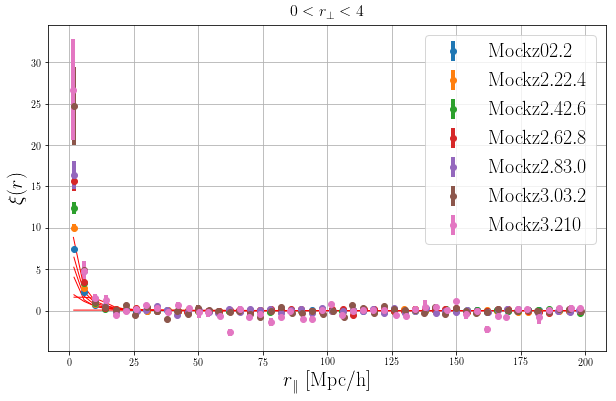

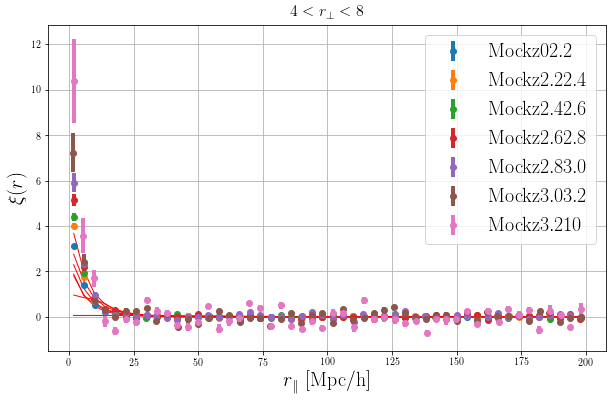

In [29]:
slices = [0, 1]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=1)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## __Compare fit results to data or theory__

In [30]:
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

In [31]:
for name,paths in sorted(toPlot.items()):
    if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
    f = h5py.File(os.path.expandvars(paths['FIT']),'r')
    toPlot[name]['FIT_RES'] = {}
    toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
    for k in list(f['best fit'].attrs['list of free pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in list(f['best fit'].attrs['list of fixed pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    f.close()

### The BAO parameters

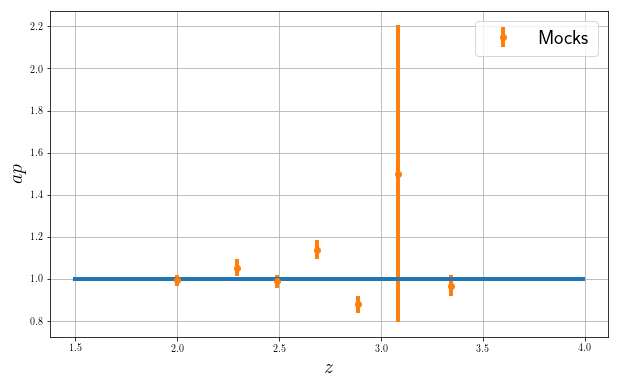

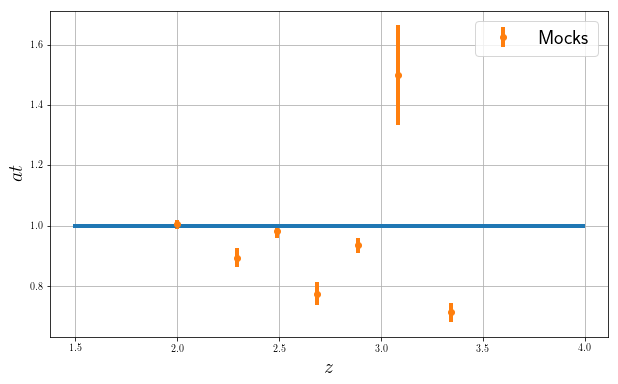

In [32]:
z = sp.arange(1.5,4.,0.01)
for p in ['ap','at']:
    plt.plot(z,sp.ones(z.size),linewidth=4)
    lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el[p][0] for el in lst ])
    zzz = sp.array([ el[p][1] for el in lst ])
    plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$'+p+'$')
    plt.legend()
    plt.grid()
    plt.show()

### The RSD parameter of the QSO

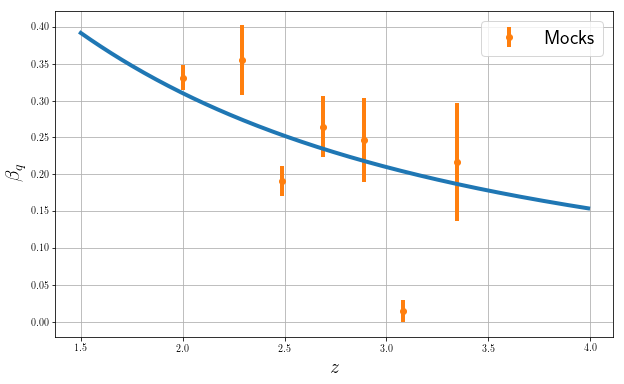

In [33]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4)

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['beta_QSO'][0] for el in lst ])
zzz = sp.array([ el['beta_QSO'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
plt.grid()
plt.show()

### The growth of structure

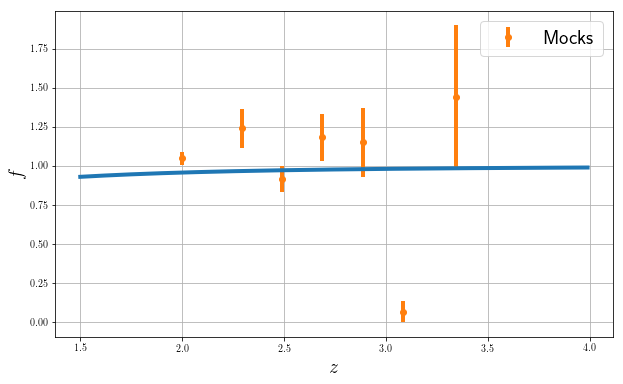

In [34]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
plt.plot(z,f,linewidth=4)

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['growth_rate'][0] for el in lst ])
zzz = sp.array([ el['growth_rate'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')

plt.xlabel(r'$z$')
plt.ylabel(r'$f$')
plt.legend()
plt.grid()
plt.show()

### The bias of the QSO

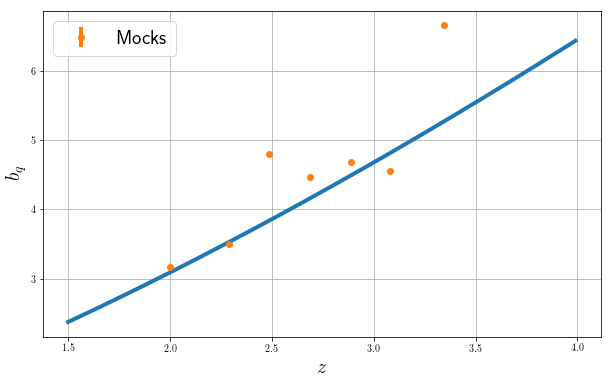

In [35]:
z = sp.arange(1.5,4.,0.01)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
plt.plot(z,bias,linewidth=4)

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['bias_QSO'][0]*el['growth_rate'][0]/el['beta_QSO'][0] for el in lst ])
zzz = sp.array([ el['bias_QSO'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')

plt.xlabel(r'$z$')
plt.ylabel(r'$b_{q}$')
plt.legend()
plt.grid()
plt.show()